In [207]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

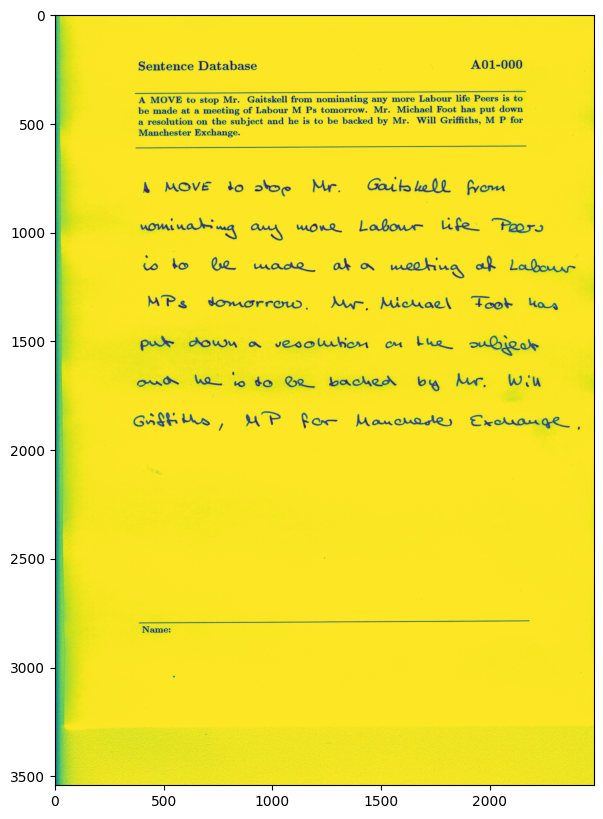

In [208]:
im = cv2.imread('data/000/a01-000u.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.imshow(im)

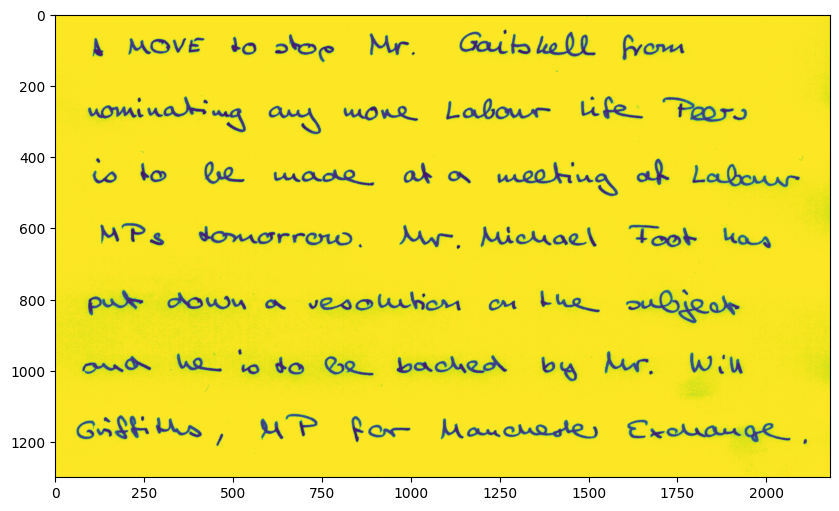

In [209]:
im = im[700:2000, 300:]
plt.figure(figsize=(10, 10))
plt.imshow(im)

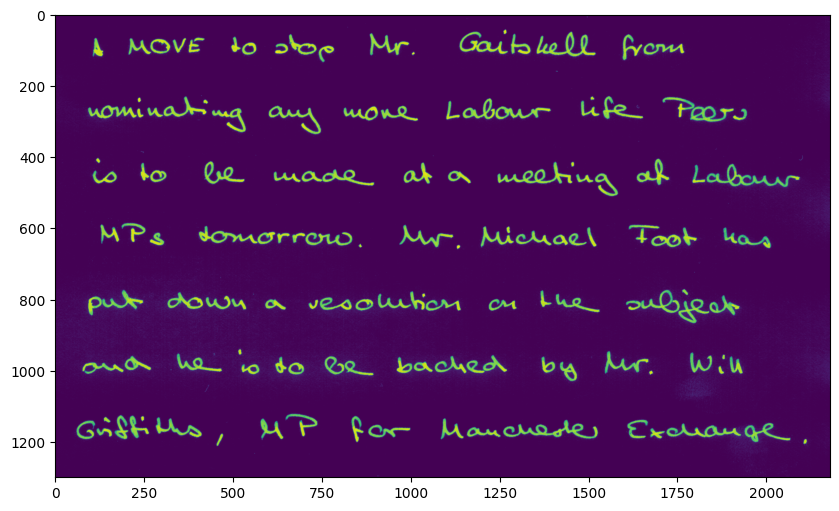

In [210]:
im = 255 - im
plt.figure(figsize=(10, 10))
plt.imshow(im)

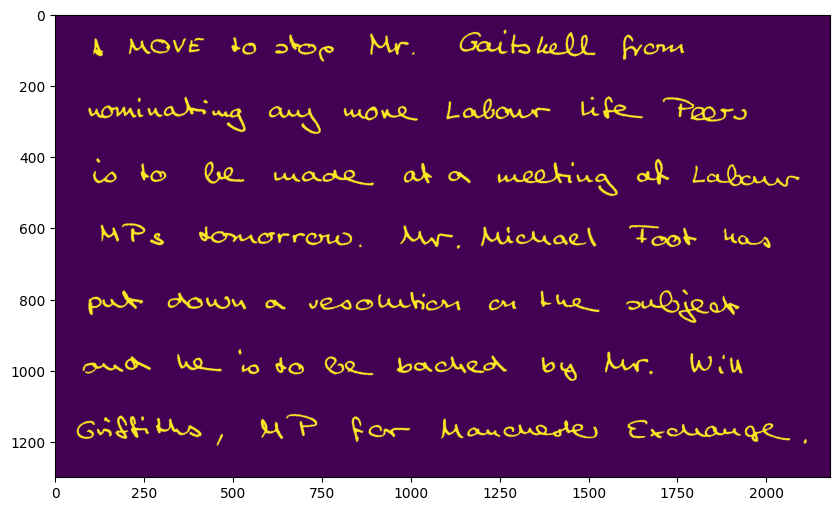

In [211]:
im = (im > 150).astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.imshow(im)

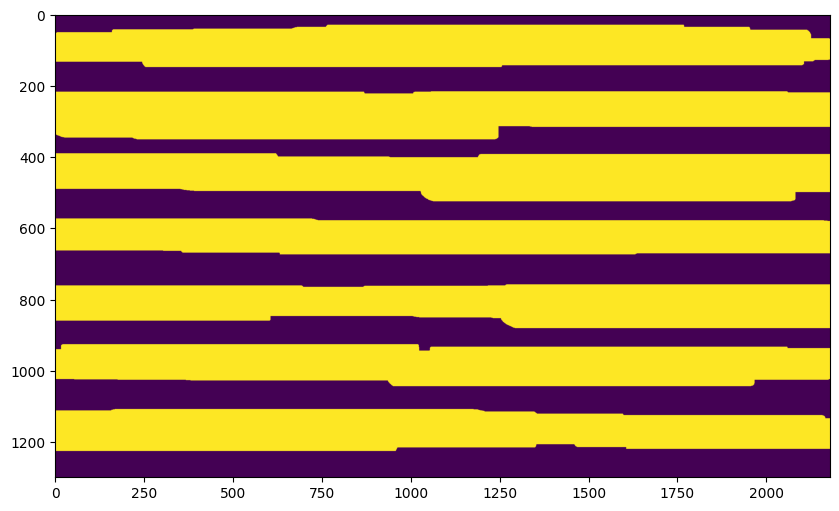

In [212]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1000, 30))
imd = cv2.dilate(im, kernel, iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(imd)

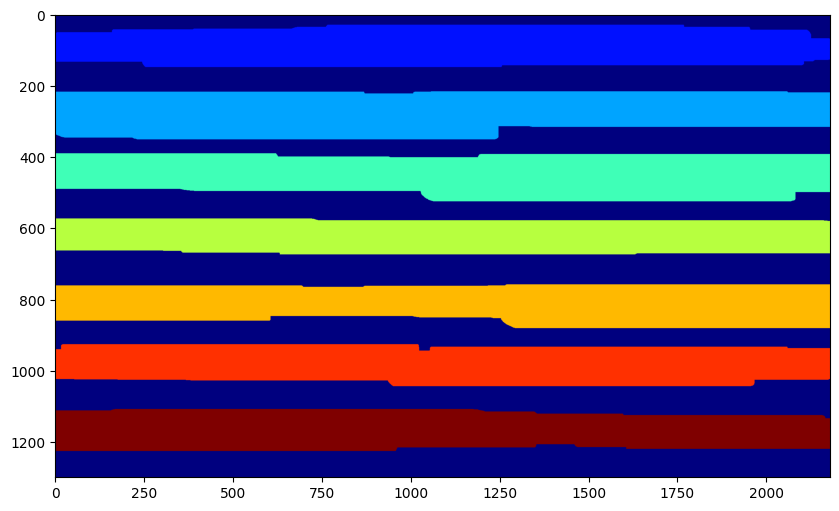

In [213]:
num_labels, labels_im = cv2.connectedComponents(imd)

plt.figure(figsize=(10, 10))
plt.imshow(labels_im, cmap='jet')

In [214]:
bounds = []
for label in range(1, num_labels):
    mask = (labels_im == label).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)
    x1, y1, x2, y2 = x, y, x + w, y + h
    bounds.append((x1, y1, x2, y2))

print(bounds)

[(0, 30, 2179, 149), (0, 217, 2179, 352), (0, 391, 2179, 526), (0, 574, 2179, 675), (0, 759, 2179, 882), (0, 927, 2179, 1045), (0, 1109, 2179, 1227)]


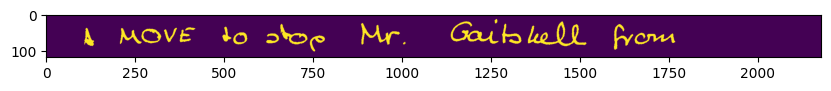

In [215]:
x1, y1, x2, y2 = bounds[0]
imr = im[y1:y2, x1:x2]
plt.figure(figsize=(10, 10))
plt.imshow(imr)

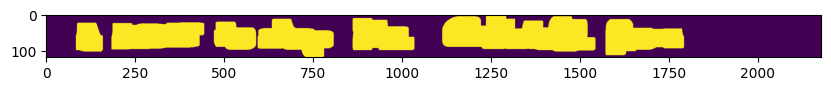

In [216]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 30))
imd = cv2.dilate(imr, kernel, iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(imd)

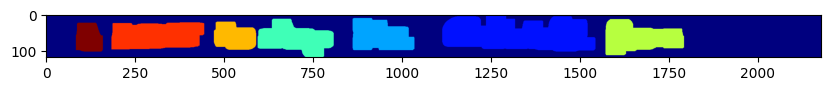

In [217]:
num_labels, labels_im = cv2.connectedComponents(imd)

plt.figure(figsize=(10, 10))
plt.imshow(labels_im, cmap='jet')

In [218]:
bounds = []
for label in range(1, num_labels):
    mask = (labels_im == label).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)
    x1, y1, x2, y2 = x, y, x + w, y + h
    bounds.append((x1, y1, x2, y2))

print(bounds)

[(1114, 0, 1545, 104), (862, 11, 1036, 100), (595, 13, 809, 119), (1573, 14, 1794, 114), (472, 21, 591, 99), (184, 23, 445, 98), (84, 24, 160, 104)]


In [219]:
bounds = sorted(bounds, key=lambda b: b[0])
print(bounds)

[(84, 24, 160, 104), (184, 23, 445, 98), (472, 21, 591, 99), (595, 13, 809, 119), (862, 11, 1036, 100), (1114, 0, 1545, 104), (1573, 14, 1794, 114)]


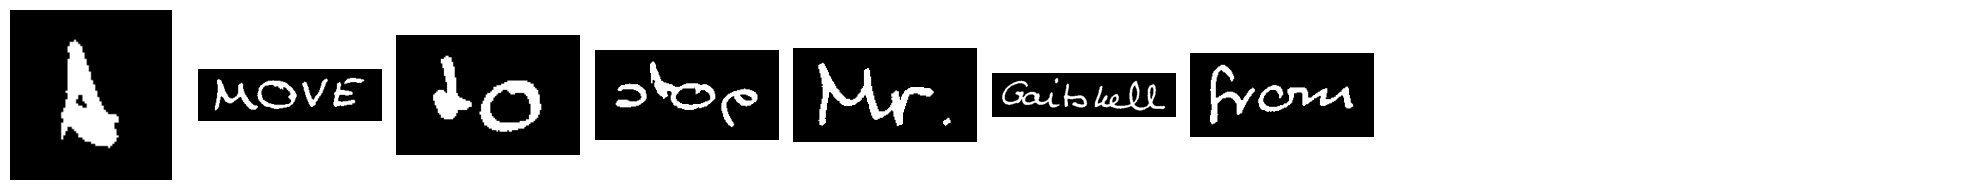

In [220]:
cols = 10
rows = (len(bounds) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
axes = axes.flatten()

for i, (x1, y1, x2, y2) in enumerate(bounds):
    axes[i].imshow(imr[y1:y2, x1:x2], cmap='gray')
    axes[i].axis('off')

# Hide any unused subplots
for i in range(len(bounds), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [221]:
import cv2
import numpy as np


def process_image_and_get_word_bounds(image_path, word_kernel_size=(50, 30), line_kernel_size=(1000, 30)):
    """
    Processes a grayscale image to extract word bounding boxes for all rows.

    Args:
        image_path (str): Path to the input image.
        word_kernel_size (tuple): Kernel size for word-level dilation.
        line_kernel_size (tuple): Kernel size for line-level dilation.

    Returns:
        list: A list of bounding boxes for all words in the format [(x1, y1, x2, y2), ...].
    """
    # Load the image in grayscale
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crop the region of interest
    im = im[700:2000, 300:]

    # Invert the image
    im = 255 - im

    # Threshold the image
    im = (im > 150).astype(np.uint8)

    # Line-level dilation
    line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, line_kernel_size)
    imd = cv2.dilate(im, line_kernel, iterations=1)

    # Connected components to find rows
    num_labels, labels_im = cv2.connectedComponents(imd)

    # Initialize a list to store all word bounds
    all_bounds = []

    # Process each row
    for label in range(1, num_labels):
        # Create a mask for the current row
        mask = (labels_im == label).astype(np.uint8)
        x, y, w, h = cv2.boundingRect(mask)
        row_im = im[y:y+h, x:x+w]

        # Word-level dilation
        word_kernel = cv2.getStructuringElement(
            cv2.MORPH_RECT, word_kernel_size)
        word_imd = cv2.dilate(row_im, word_kernel, iterations=1)

        # Connected components to find words
        num_word_labels, word_labels_im = cv2.connectedComponents(word_imd)

        # Extract word bounding boxes
        row_bounds = []
        for word_label in range(1, num_word_labels):
            word_mask = (word_labels_im == word_label).astype(np.uint8)
            wx, wy, ww, wh = cv2.boundingRect(word_mask)
            # Adjust coordinates to the original image
            row_bounds.append((x + wx, y + wy, x + wx + ww, y + wy + wh))

        # Sort words within the row by x-coordinate
        row_bounds = sorted(row_bounds, key=lambda b: b[0])

        # Extend the all_bounds list with the sorted row bounds
        all_bounds.extend(row_bounds)

    return all_bounds


# Example usage
bounds = process_image_and_get_word_bounds('data/000/a01-000u.png')
print(bounds)

[(84, 54, 160, 134), (184, 53, 445, 128), (472, 51, 591, 129), (595, 43, 809, 149), (862, 41, 1036, 130), (1114, 30, 1545, 134), (1573, 44, 1794, 144), (70, 218, 561, 347), (577, 244, 772, 352), (788, 244, 1045, 315), (1077, 223, 1418, 311), (1456, 217, 1678, 309), (1685, 220, 1970, 317), (83, 391, 198, 490), (217, 405, 338, 487), (397, 400, 557, 491), (592, 423, 922, 497), (957, 404, 1194, 490), (1221, 402, 1607, 526), (1612, 393, 1752, 495), (1769, 408, 2119, 500), (104, 574, 331, 664), (381, 582, 888, 670), (946, 579, 1164, 675), (1174, 583, 1547, 668), (1590, 579, 1829, 669), (1857, 588, 2037, 672), (70, 762, 273, 861), (293, 768, 562, 845), (568, 788, 673, 845), (690, 766, 1165, 848), (1196, 787, 1322, 847), (1342, 763, 1556, 852), (1582, 759, 1950, 882), (54, 947, 295, 1025), (320, 941, 494, 1019), (492, 927, 725, 1027), (735, 948, 920, 1029), (937, 945, 1296, 1024), (1345, 949, 1492, 1045), (1523, 934, 1706, 1027), (1762, 938, 1958, 1025), (37, 1113, 497, 1227), (555, 1109, 762,

[(84, 54, 160, 134), (184, 53, 445, 128), (472, 51, 591, 129), (595, 43, 809, 149), (862, 41, 1036, 130), (1114, 30, 1545, 134), (1573, 44, 1794, 144), (70, 218, 561, 347), (577, 244, 772, 352), (788, 244, 1045, 315), (1077, 223, 1418, 311), (1456, 217, 1678, 309), (1685, 220, 1970, 317), (83, 391, 198, 490), (217, 405, 338, 487), (397, 400, 557, 491), (592, 423, 922, 497), (957, 404, 1194, 490), (1221, 402, 1607, 526), (1612, 393, 1752, 495), (1769, 408, 2119, 500), (104, 574, 331, 664), (381, 582, 888, 670), (946, 579, 1164, 675), (1174, 583, 1547, 668), (1590, 579, 1829, 669), (1857, 588, 2037, 672), (70, 762, 273, 861), (293, 768, 562, 845), (568, 788, 673, 845), (690, 766, 1165, 848), (1196, 787, 1322, 847), (1342, 763, 1556, 852), (1582, 759, 1950, 882), (54, 947, 295, 1025), (320, 941, 494, 1019), (492, 927, 725, 1027), (735, 948, 920, 1029), (937, 945, 1296, 1024), (1345, 949, 1492, 1045), (1523, 934, 1706, 1027), (1762, 938, 1958, 1025), (37, 1113, 497, 1227), (555, 1109, 762,

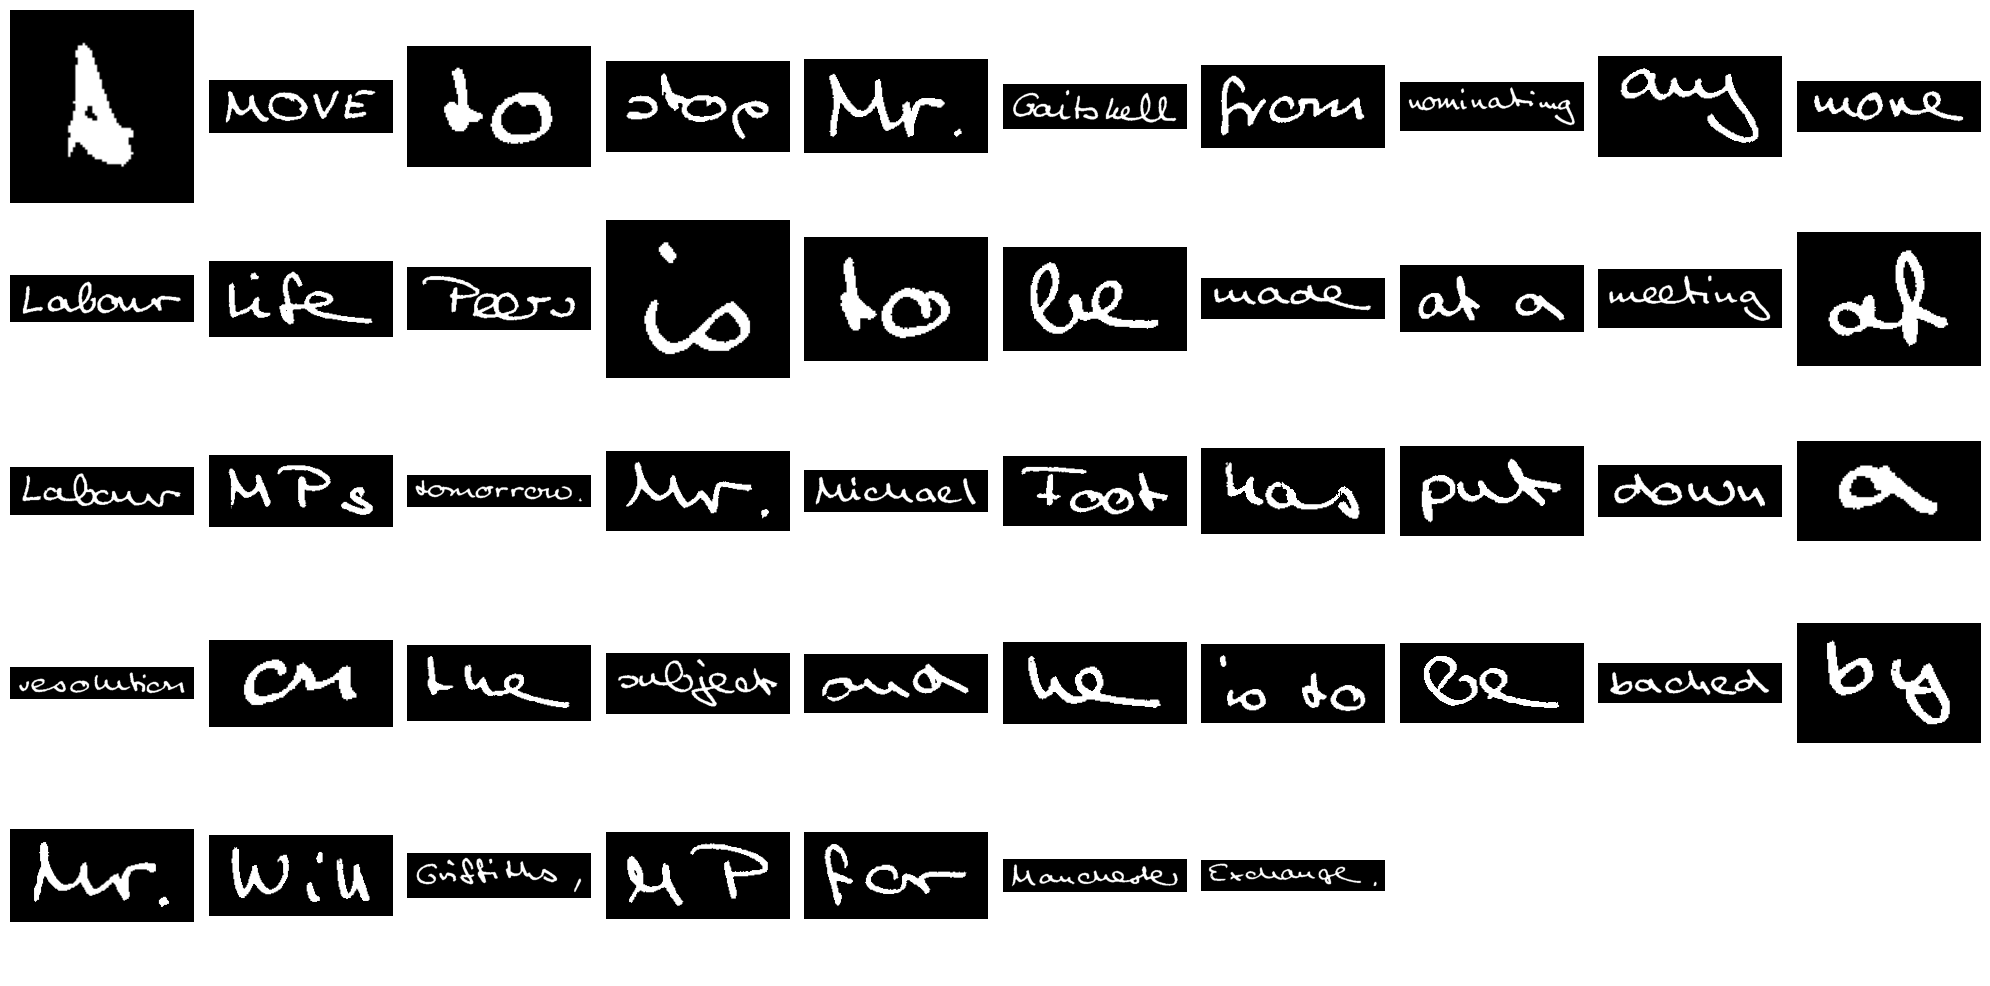

In [222]:
# Example usage
bounds = process_image_and_get_word_bounds('data/000/a01-000u.png')
print(bounds)

cols = 10
rows = (len(bounds) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
axes = axes.flatten()

for i, (x1, y1, x2, y2) in enumerate(bounds):
    axes[i].imshow(im[y1:y2, x1:x2], cmap='gray')
    axes[i].axis('off')

# Hide any unused subplots
for i in range(len(bounds), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

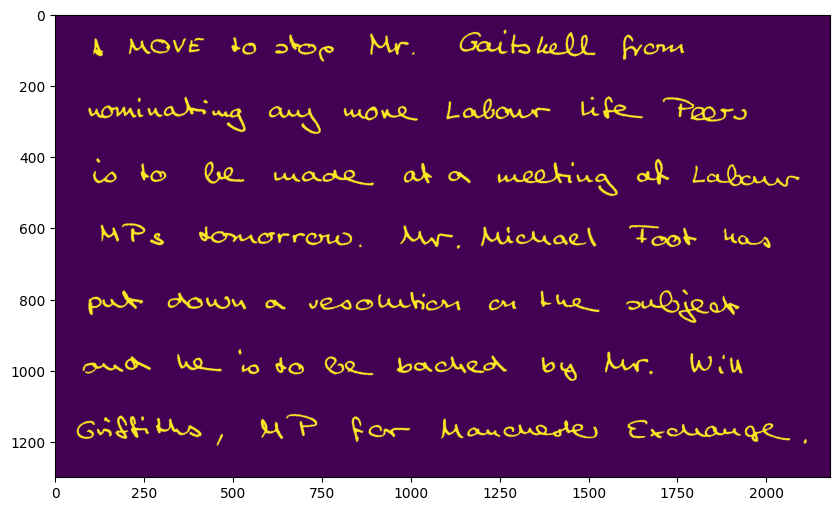

In [226]:
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.show()